In [1]:
# packages: ; pysurfer
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt

## General remarks

Source localization is hard. There are numerous moving parts, many parameters and decisions, and a complex chain of tools. Especially the part named "structural information" makes use of the Freesurfer tool, which is a tool that needs quite some time to understand the underlying functionalities, intrications and output. This box depicts how to get from an MRI to a 3D-surface/headmodel & how to align this headmodel to the coordinate system of your electrode sensors. 


![MNE Flow](https://mne.tools/stable/_images/flow_diagram.svg)

We will skip these steps completly and start with an already-segment "default" MRI (called 'fsaverage'). 

### **Important:**
 Source-reconstructions with a default-MRI (opposite of a individual MRI) introduces even more noise (=uncertainty) than already existing in "optimal" source localization. Your source-localizations should therefore be interpreted even more carefully than with individual MRIs. Never let yourself be fooled by the apparent precision of source-localizations!!


# Setup
We first need to install the python packages "pyvista" & "pyvistaqt"

### !! 3D Frustration alert!! 
3D Plots are annoying. They crash your system, they are slow, they are unstable. The frustration is normal and unfortunately still to be expected.

### Actual start of exercise


Next we have to do some downloading, i.e. download the average-brain MRI and the pre-computed headmodel (BEM-method)

```python

import os.path as op

import mne
from mne.datasets import eegbci
from mne.datasets import fetch_fsaverage

# Download fsaverage files
fs_dir = fetch_fsaverage(verbose=True)
subjects_dir = op.dirname(fs_dir)

# The files live in:
subject = 'fsaverage'
trans = 'fsaverage'  # MNE has a built-in fsaverage transformation
src = op.join(fs_dir, 'bem', 'fsaverage-ico-5-src.fif')
bem = op.join(fs_dir, 'bem', 'fsaverage-5120-5120-5120-bem-sol.fif')
```

In [2]:

import os.path as op

import mne
from mne.datasets import eegbci
from mne.datasets import fetch_fsaverage

# Download fsaverage files
fs_dir = fetch_fsaverage(verbose=True)
subjects_dir = op.dirname(fs_dir)

# The files live in:
subject = 'fsaverage'
trans = 'fsaverage'  # MNE has a built-in fsaverage transformation
src = op.join(fs_dir, 'bem', 'fsaverage-ico-5-src.fif')
bem = op.join(fs_dir, 'bem', 'fsaverage-5120-5120-5120-bem-sol.fif')

0 files missing from root.txt in /home/ehinger/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /home/ehinger/mne_data/MNE-fsaverage-data/fsaverage


Next we need a dataset that we want to source localize. We will use the LIMO dataset, which has lot's of trials, but unfortauntely neither individual headmodel, nor individual electrode-positions.

```python
from mne.datasets.limo import load_data
epochs = load_data(subject=3,path='../local/limo') #
epochs.set_eeg_reference(projection=True)  # needed for inverse modeling
```

In [3]:
from mne.datasets.limo import load_data
epochs = load_data(subject=3,path='../local/limo') #
epochs.set_eeg_reference(projection=True)  # needed for inverse modeling


Adding metadata with 2 columns
1072 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.


Number of events,1072
Events,Face/A: 538Face/B: 534
Time range,-0.300 – 0.500 sec
Baseline,off


### Alignment of brains and sensors
It is of outmost importance, to align sensors and brains. This can be a very tricky task if you have individual MRIs & headmodels, because brains are mirror-symmetric and electrode locations as well. Thus R/L Flips are common.

Typically we define 3 anatomical landmarks, the nasion (between your eyes) and the Auricular Points Left and Right, a point just infront of your ear-canals. These points can be defined in your electrode-locations (e.g. using a digitizer), and are visible in the MRI. 

Luckily, for us everything is alligned already and we can plot it using:
```python
# Check that the locations of EEG electrodes is correct with respect to MRI

p = mne.viz.plot_alignment(
    epochs.info, src=src, eeg=['original', 'projected'], trans=trans,
    show_axes=True, mri_fiducials=True, dig='fiducials')

p
```
**Hint:** You can close the 3D plots using `p.plotter.close()` and later plots using `b.close()`. At least on my machine I had many crashes if I kept them floating around...

In [18]:
# Check that the locations of EEG electrodes is correct with respect to MRI

mne.viz.set_3d_backend("notebook")

p = mne.viz.plot_alignment(
    epochs.info, src=src, eeg=['original', 'projected'], trans="fsaverage", # try trans=None for fun
    show_axes=True, mri_fiducials=True, dig='fiducials')

p

Reading /home/ehinger/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif...
Using outer_skin.surf for head surface.
Channel types::	eeg: 121
Projecting sensors to the head surface


# The forward model

The forward model translates source-activity to sensor-activity. We have to provide the sensor locations (`epochs.info`), the **trans**formations of sensorlocations to BEM model (`trans`) and the actual physical spheres (bem). The default conductivities for the BEM model are already saved in the pre-computed standard BEM model.



In [19]:
fwd = mne.make_forward_solution(epochs.info, trans=trans, src=src, bem=bem, eeg=True, mindist=5.0)


Source space          : /home/ehinger/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif
MRI -> head transform : /home/ehinger/miniconda3/envs/eegCourse/lib/python3.10/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : /home/ehinger/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-5120-5120-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading /home/ehinger/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif...
Read 2 source spaces a total of 20484 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read 128 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Setti

In [20]:
fwd["sol"]["data"].shape

(128, 61452)

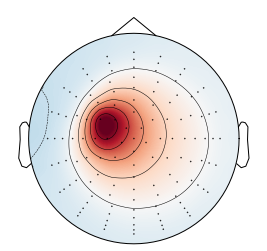

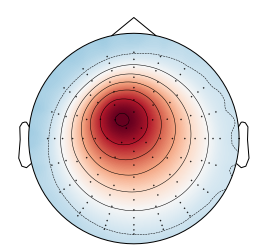

(<matplotlib.image.AxesImage at 0x7f4293e5b2e0>,
 <matplotlib.contour.QuadContourSet at 0x7f4293e5b5e0>)

In [25]:
%matplotlib inline

mne.viz.plot_topomap(fwd["sol"]["data"][:,2],epochs.info)
from matplotlib import pyplot as plt
plt.figure()
mne.viz.plot_topomap(fwd["sol"]["data"][:,8],epochs.info)


The leadfield can be extracted by `fwd["sol"]["data"]`. 

**T:** What is the shape of the leadfield and what do the dimension refer to?

**T:** select a random source-point and plot its respective sensor-topoplot (`mne.viz.plot_topomap(vector,epochs.info)`)

**T:** Next plot three following source-points. Be sure to start with 0,3,6,9... (e.g. multiply your random "starting"-index by 3).What do you observe and what does it tell you about the structure of the forward model? (hint: you could also inspect `fwd["source_nn"]`) - `plot_topomap` has an "axes" option to specify subplot-axes, be sure to put `show=False` if you want to use that.

(128, 61452)


<Figure size 432x288 with 0 Axes>

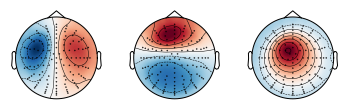

In [32]:
import mne.viz
print(fwd["sol"]["data"].shape)
#mne.viz.plot_topomap(fwd["sol"]["data"][:,1],epochs.info);
plt.figure()
fig,ax = plt.subplots(1,3)
for ix in range(3):
    mne.viz.plot_topomap(fwd["sol"]["data"][:,6+ix],epochs.info,axes=ax[ix],show=False);
plt.show();

Now we will plot the reverse, choose one electrode and see which sources are most sensitive to that electrode. Note that you only need every third sample, i.e. we are looking for the activity at the cortex in only one dimension. It is a bit more involved to collapse over all source-orientations.

To plot the vector on a 3D brain, you can use this piece of code:

```python

from mne.datasets import fetch_fsaverage
from surfer import Brain
fs_dir = fetch_fsaverage(verbose=True)
subjects_dir = op.dirname(fs_dir)

# generate Brain Plot
b = Brain('fsaverage', "lh", "white", background='white',subjects_dir=subjects_dir)

# get the surface model, get the left-hemisphere (`0`), geht the vertice-indices
v = fwd["src"][0]['vertno']
nvert = len(v)

# x is the leadfield slice spanning both hemisphere, we going to take only the first half of it.
b.add_data(x[0:nvert],vertices=v,smoothing_steps='nearest')
´´´

In [14]:
from mne.viz import Brain

b = Brain('fsaverage', "lh", "white", background='white',subjects_dir=subjects_dir)

x = fwd["sol"]["data"][6,::3]

nvert = len(fwd["src"][0]['vertno'])
v = fwd["src"][0]['vertno']
#v = fwd["src"][0]["use_tris"]
print(len(v))
#b.add_overlay()
b.add_data(x[0:nvert],vertices=v,smoothing_steps='nearest')

10242


In [ ]:
b.close()

# Inverse Solutions
### My first MNE

We learned in the lecture, that the Minimum Norm Solution, is simply the pseudo-inverse of the leadfield matrix. 

**T:** To get started, plot the evoked data once more to remember what the ERP looks like. We want to zoom in the component which has its strongest activity around 150ms.

**T:** Use `from scipy.linalg import pinv` on one orientation of the Leadfield (`fwd["sol"]["data"][:,::3]`) and `@`-multiply it on your `epochs.copy().crop(tmin=0.15,tmax=0.15).average().interpolate_bads().data[:,0]` - you need to interpolate the bad channels, else they will project noise to your source-space

**T:** Plot a histogram of your source values. Do negative values make sense (solution below, don't peak ;))?

**Bonus:** instead of cropping to around 150ms, you can also calculate all timepoints and later select a timepoint, but it is a bit more cumbersome to handle everything

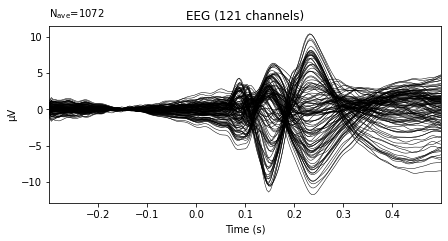

In [ ]:
epochs.average().plot();

In [33]:
L = fwd["sol"]["data"][:,::3]
L.shape

(128, 20484)

In [34]:
d = epochs.copy().crop(tmin=0.150,tmax=0.153).average().interpolate_bads().data
d.shape
from scipy.linalg import pinv

MNE = pinv(L)

MNE.shape

Interpolating bad channels
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 121 sensor positions
Interpolating 7 sensors


(20484, 128)

In [35]:
from scipy.linalg import pinv

L = fwd["sol"]["data"][:,::3]

MNE = pinv(L)

d = epochs.copy().crop(tmin=0.150,tmax=0.153).average().interpolate_bads().data
s = MNE@d


Interpolating bad channels
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 121 sensor positions
Interpolating 7 sensors


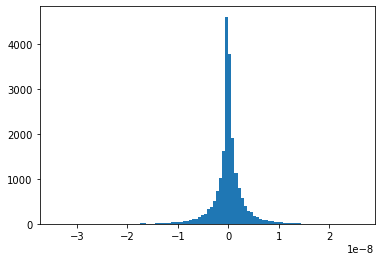

In [ ]:
plt.hist(s,100);

Once we have the vector of source-activities, we want to plot it

```python
%gui qt
from surfer import Brain
import numpy as np

# generate brain
b = Brain('fsaverage', "lh", "white", background='white',subjects_dir=subjects_dir)

# which vertices to plot?
v = fwd["src"][0]['vertno']
nvert = len(v)

# add the data to the plot - note we are using np.abs here!
b.add_data(np.abs(s[0:nvert]),vertices=v,colormap="hot")

# use some kind of sensible colormap
lim = np.percentile(np.abs(s),[30,80,98])
b.scale_data_colormap(fmin=lim[0], fmid=lim[1], fmax=lim[2], transparent=True)
```

Note the usage of np.abs around the source activity. It is generally not really possible to interpret positive / negative source activity. if you are on one side of a gyrus, the activity might be positive, on the other side it might be negative - simply because of dipole orientation. We therefore often just look at the absolute value

**Bonus:** If you wanted to plot all time-points, you can use `b.set_time(200)` to set time, or  `from surfer import TimeViewer` and `viewer = TimeViewer(b)` to get a rudimentairy GUI

In [37]:
v = fwd["src"][0]['vertno']
v

array([    0,     1,     2, ..., 10239, 10240, 10241])

In [ ]:
%gui qt
from surfer import Brain
import numpy as np
b = Brain('fsaverage', "lh", "white", background='white',subjects_dir=subjects_dir)
nvert = len(fwd["src"][0]['vertno'])
v = fwd["src"][0]['vertno']
print(len(v))
b.add_data(np.abs(s[0:nvert]),vertices=v,colormap="hot")

lim = np.percentile(np.abs(s),[30,80,98])
b.scale_data_colormap(fmin=lim[0], fmid=lim[1], fmax=lim[2], transparent=True)


10242


In [ ]:
b.close()

### Finishing words to the manual implementation
This toy-implementation has two serious limitations: 

    - no control over how much regularisation
    - only one orientation of the Leadfield was used
    
We will fix those using the MNE functionalities next.  


# Covariance Matrices
It turns out, calculating the MNE solution via pseudoinverse is not necessarily the most versatile approach. the MNE toolbox (this is b.t.w. where the name originally came from), decided that a different parameterization is useful.

They build everything around "noise-covariance" over channels. I.e. in a period of time where no systematic activity happens, how much do channels covary? 
Why is this useful? It is useful for regularisation. Naively we could regularize all activity, but it would be more effective, if we could regularize noise more than signal. Thus, if we know something about the structure of the noise (the channel noise-covariance), we can regularize more effectively.

*As a sidenote:* This is also convenient for the LCMV-beamformer: there we would need not the noise-covariance, but the data-covariances (how do channels covary if to-be-explained activity is present [per condition])

*Another sidenote:* In case we would want to recover the original MNE solution, we'd have to input a identity-matrix as the covariance matrix.

**T:** Calculate the covariance matrix for noise and plot it:
```python
noise_cov = mne.compute_covariance(epochs, tmax=0)
noise_cov.plot(epochs.info)
```

**Q:** What does the 2d-image plot tell you?

Computing rank from data with rank=None


/tmp/ipykernel_2058897/3142076790.py:1: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  noise_cov = mne.compute_covariance(epochs, tmax=0)


    Using tolerance 1.5e-10 (2.2e-16 eps * 121 dim * 5.5e+03  max singular value)
    Estimated rank (eeg): 120
    EEG: rank 120 computed from 121 data channels with 1 projector
    Created an SSP operator (subspace dimension = 1)
    Setting small EEG eigenvalues to zero (without PCA)
Reducing data rank from 121 -> 120
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 81472
[done]
Computing rank from covariance with rank=None
    Using tolerance 1e-13 (2.2e-16 eps * 121 dim * 3.7  max singular value)
    Estimated rank (eeg): 120
    EEG: rank 120 computed from 121 data channels with 0 projectors


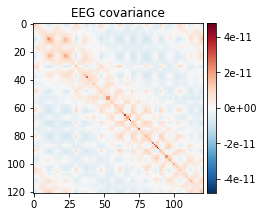

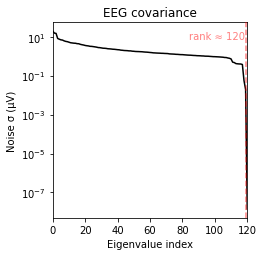

(<Figure size 273.6x266.4 with 2 Axes>, <Figure size 273.6x266.4 with 1 Axes>)

In [38]:
noise_cov = mne.compute_covariance(epochs, tmax=0)
noise_cov.plot(epochs.info)


#### Inverse Operator

Next, we need to specify the inverse operator, this is where Leadfield (forward model) and noise-covariance meet. This is also where we could constrict the orientations of our dipoles to be orthogonal to the cortex & where we could use depth-correction of the leadfield.

We generate an inverse operator like this:
```python
from mne.minimum_norm import make_inverse_operator, apply_inverse
inv_default = make_inverse_operator(epochs.info, fwd, noise_cov, loose=0.2, depth=0.8)
```
**T:** Generate three more operator, one with loose=1, allowing for all dipole orientations, one with loose=0, enforcing strict orthogonal orientation (don't do that) and one with loose=0.2, but depth=0. - deactivating depth weighting.

In [40]:
from mne.minimum_norm import make_inverse_operator, apply_inverse

inv_default= make_inverse_operator(epochs.info, fwd, noise_cov, loose=0.2, depth=0.8)
inv_loose0 = make_inverse_operator(epochs.info, fwd, noise_cov, loose=0,   depth=0.8)
inv_loose1 = make_inverse_operator(epochs.info, fwd, noise_cov, loose=1,   depth=0.8)
inv_depth0 = make_inverse_operator(epochs.info, fwd, noise_cov, loose=0.2, depth=0.)


Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
info["bads"] and noise_cov["bads"] do not match, excluding bad channels from both
Computing inverse operator with 121 channels.
    121 out of 128 channels remain after picking
Selected 121 channels
Creating the depth weighting matrix...
    121 EEG channels
    limit = 20485/20484 = 2.572931
    scale = 174000 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 1e-13 (2.2e-16 eps * 121 dim * 3.7  max singular value)
    Estimated rank (eeg): 120
    EEG: rank 120 computed from 121 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without PCA)
Cr

#### Applying the inverse
Next, we have to apply the inverse operator.
For this, we still need to define how much regularisation we want to apply. If we expect noisy data, we should put lot's of regularisation. If we expect high SNR, there should be less regularisation. Here the MNE implementation really shines: We can easily define a Signal-To-Noise ratio and translate it to a regularisation parameter that will fit.
```python
snr = 10.0
lambda2 = 1.0 / snr ** 2
```

**T:** calculate the inverse solution and get the stc (source time course) for the `inv_default` - choose the MNE algorithm in the function `mne.minimum_norm.apply_inverse`
**T:** Plot it! `brain = stc.plot(time_viewer=True,hemi="both")`


In [41]:
snr = 10.0
lambda2 = 1.0 / snr ** 2
stc = apply_inverse(epochs.average(), inv_default, lambda2, 'MNE')#, pick_ori='vector')

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1072
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 120 (1 small eigenvalues omitted)
Applying inverse operator to "0.50 × Face/A + 0.50 × Face/B"...
    Picked 121 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  46.4% variance
    Combining the current components...
[done]


In [42]:
brain = stc.plot(time_viewer=True,hemi="both")

Using control points [8.26314785e-12 9.82639882e-12 2.66900633e-11]


<IPython.core.display.Javascript object>

**Bonus:** You can also plot the brain activity on a "inflated" or "flat" brain using `surface = "flat"` (or inflated respectively). This can be very helpful in comparing conditions etc. - but especially the flat map will be very hard to read for everyone who is not a brain-anatomy-expert

In [43]:
stc.plot(surface="flat",time_viewer=True)
#stc.plot(surface="flat",time_viewer=True)

Using control points [8.26314785e-12 9.82639882e-12 2.66900633e-11]


<IPython.core.display.Javascript object>

# Comparing Inverse Solutions
We will do a set of source-solution comparisons. Note that this is just one example, and just a subset of all possible parameters. It might give you a small glimpse, and maybe even only a missleading intuition. But still, at least it will give you a starting point for experience in source localization.

### Comparing our dipole-orientation & depth models
I feel like this exercise is already pretty long, so I will give you larger chunks of code.

```python
# plotting parameters
brain_kwargs = dict(views="lateral",hemi='split', size=(800, 400), initial_time=0.15,time_viewer=False,time_unit='s',show_traces=False)

# getting larger figures
plt.rcParams['figure.dpi'] = 100 
plt.rcParams["figure.figsize"] = (20,15)

# a list of all our inverse operators
sourceList = [inv_default,inv_loose0,inv_loose1,inv_depth0]

#loop over inverse operators
for (ix,inv) in enumerate(sourceList):

    # calculate the stc
    s = apply_inverse(epochs.average(), inv, lambda2, 'MNE', verbose=True)#, pick_ori='vector')
    
    # plot it
    h = s.plot(**brain_kwargs)

    # grab a png from it
    img = ccs_eeg_utils.stc_plot2img(h,closeAfterwards=False)

    # add the png to a subplot
    ax = plt.subplot(2,2,ix+1).imshow(img)
    plt.axis('off')

```



Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1072
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 120 (1 small eigenvalues omitted)
Applying inverse operator to "0.50 × Face/A + 0.50 × Face/B"...
    Picked 121 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  46.4% variance
    Combining the current components...
[done]
Using control points [8.26314785e-12 9.82639882e-12 2.66900633e-11]


Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1072
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 120 (1 small eigenvalues omitted)
Applying inverse operator to "0.50 × Face/A + 0.50 × Face/B"...
    Picked 121 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  46.1% variance
[done]
Using control points [1.15861132e-11 1.38390192e-11 3.79632677e-11]


Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1072
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 120 (1 small eigenvalues omitted)
Applying inverse operator to "0.50 × Face/A + 0.50 × Face/B"...
    Picked 121 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  46.6% variance
    Combining the current components...
[done]
Using control points [6.45174951e-12 7.36806058e-12 1.54805434e-11]


Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1072
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 120 (1 small eigenvalues omitted)
Applying inverse operator to "0.50 × Face/A + 0.50 × Face/B"...
    Picked 121 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  47.9% variance
    Combining the current components...
[done]
Using control points [8.20140165e-12 1.00116981e-11 3.64245943e-11]


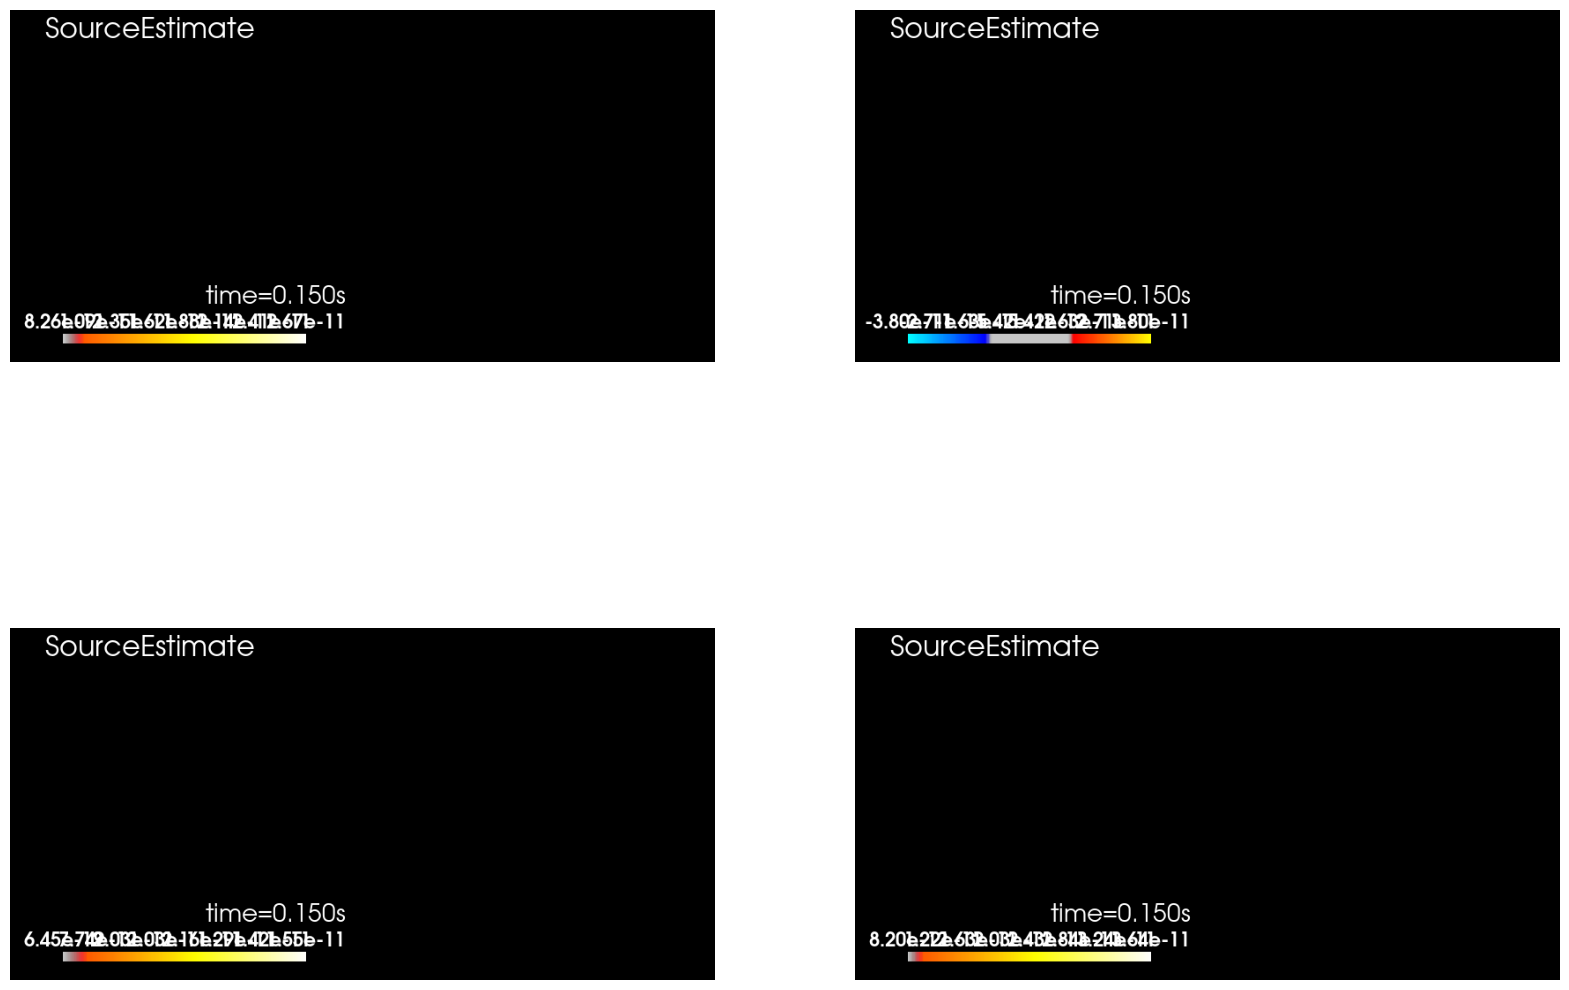

In [46]:
import sys
sys.path.insert(0,"..")

import ccs_eeg_utils
brain_kwargs = dict(views='flat',surface="flat", hemi='split', size=(800, 400), initial_time=0.15,time_viewer=False,time_unit='s',show_traces=False)
# plotting parameters
brain_kwargs = dict(views="lateral",hemi='split', size=(800, 400), initial_time=0.15,time_viewer=False,time_unit='s',show_traces=False)

# getting larger figures
plt.rcParams['figure.dpi'] = 100 
plt.rcParams["figure.figsize"] = (20,15)

# a list of all our inverse operators
sourceList = [inv_default,inv_loose0,inv_loose1,inv_depth0]

#loop over inverse operators
for (ix,inv) in enumerate(sourceList):

    # calculate the stc
    s = apply_inverse(epochs.average(), inv, lambda2, 'MNE', verbose=True)#, pick_ori='vector')
    
    # plot it
    h = s.plot(**brain_kwargs)

    # grab a png from it
    img = ccs_eeg_utils.stc_plot2img(h,closeAfterwards=False)

    # add the png to a subplot
    ax = plt.subplot(2,2,ix+1).imshow(img)
    plt.axis('off')


**Bonus-Q:** Why did MNE suddenly decide to plot pos/neg for the loose=0 (fixed orientation) instead of abs?

#### Comparing algorithms
Next we will compare the four different minimum-norm algorithms implemented in MNE:
`['MNE','sLORETA','eLORETA','dSPM']`
adapt the previous script to use `inv_default` for all of them and plot the solutions again.

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1072
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 120 (1 small eigenvalues omitted)
Applying inverse operator to "0.50 × Face/A + 0.50 × Face/B"...
    Picked 121 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  46.4% variance
    Combining the current components...
[done]
Using control points [8.26314785e-12 9.82639882e-12 2.66900633e-11]


Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1072
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 120 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Applying inverse operator to "0.50 × Face/A + 0.50 × Face/B"...
    Picked 121 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  46.4% variance
    Combining the current components...
    sLORETA...
[done]
Using control points [18.43577167 21.42066689 46.66754233]


Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1072
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 120 (1 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Using independent orientation weights
        Fitting up to 20 iterations (this make take a while)...
        Converged on iteration 10 (4.8e-07 < 1e-06)
        Updating inverse with weighted eigen leads
[done]
Applying inverse operator to "0.50 × Face/A + 0.50 × Face/B"...
    Picked 121 channels from the data
    Computing inverse...
    Eigenleads already weighted ... 
    Computing residual...
    Explained  45.4% variance
    Combining the current components...
[done]
Using control points [7.39223674e-12 8.42494906e-12 1.71655980e-11]


Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1072
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 120 (1 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "0.50 × Face/A + 0.50 × Face/B"...
    Picked 121 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  46.4% variance
    Combining the current components...
    dSPM...
[done]
Using control points [34.68525843 40.1269434  92.54111535]


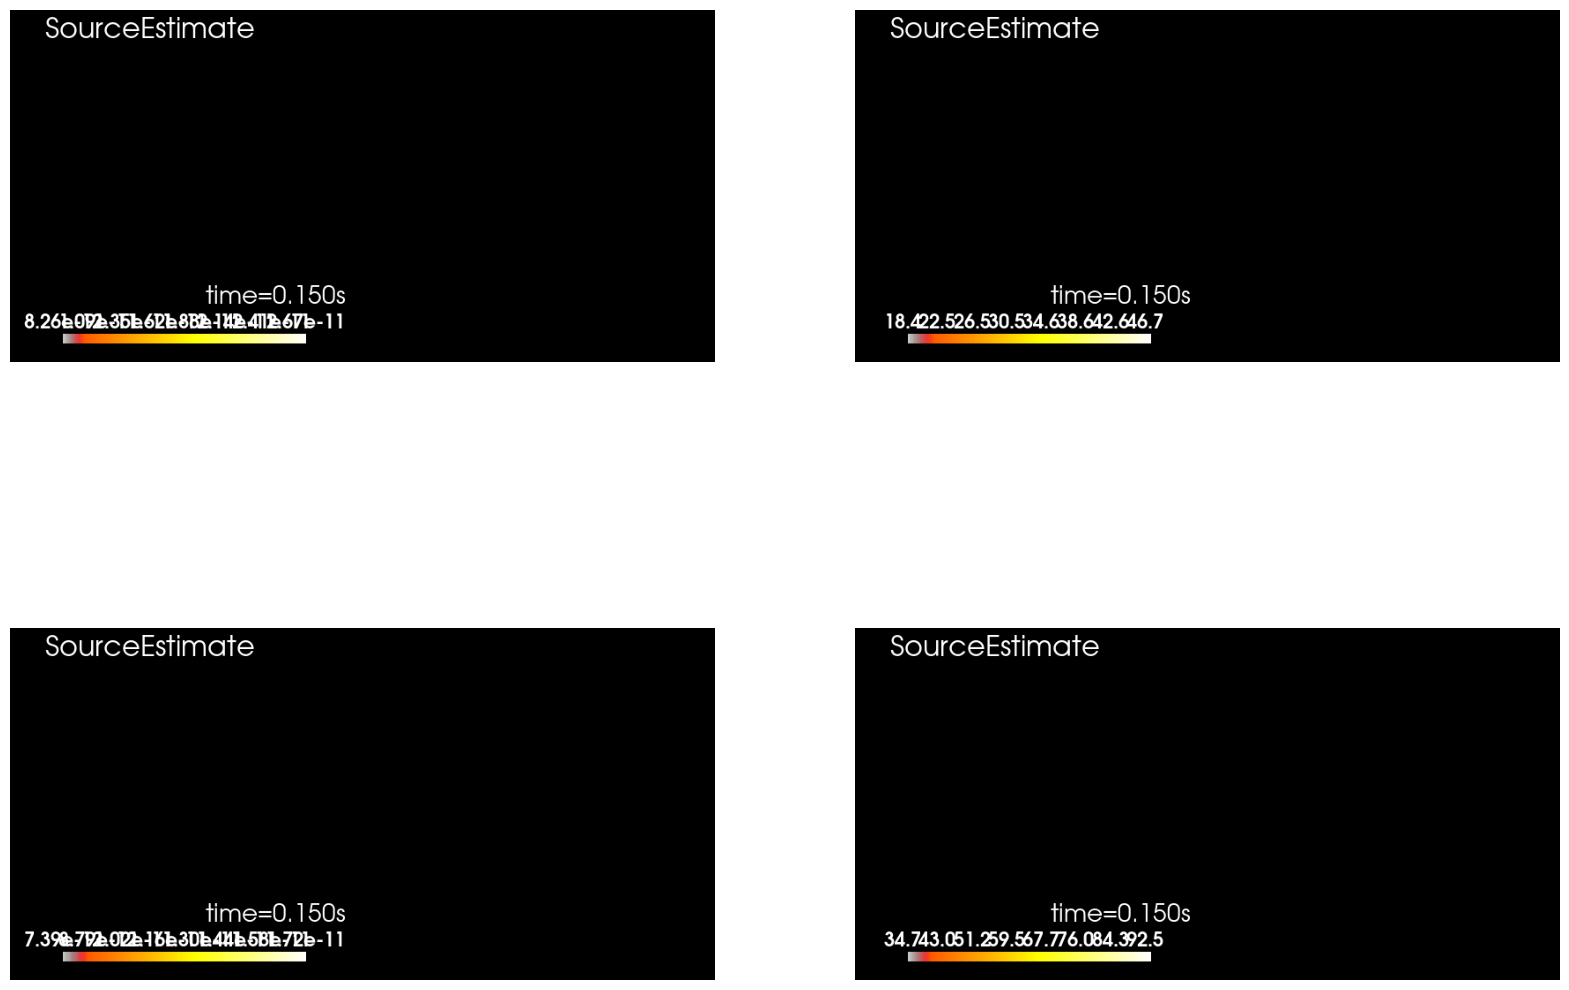

In [47]:
# plotting parameters
brain_kwargs = dict(views="lateral",hemi='split', size=(800, 400), initial_time=0.15,time_viewer=False,time_unit='s',show_traces=False)

# getting larger figures
plt.rcParams['figure.dpi'] = 100 
plt.rcParams["figure.figsize"] = (20,15)

# a list of all our inverse operators

#loop over inverse operators
for (ix,method) in enumerate(['MNE','sLORETA','eLORETA','dSPM']):

    # calculate the stc
    s = apply_inverse(epochs.average(), inv_default, lambda2, method, verbose=True)#, pick_ori='vector')
    
    # plot it
    h = s.plot(**brain_kwargs)

    # grab a png from it
    img = ccs_eeg_utils.stc_plot2img(h,closeAfterwards=False)

    # add the png to a subplot
    ax = plt.subplot(2,2,ix+1).imshow(img)
    plt.axis('off')


#### Final exploration: Different regularisation
Adapt the above script once more, and apply different SNRs (e.g. `[0.1,2,10,50]`). What do you observe?
Make note of the MNE text-output, it tells you how much % of your actual observed data is explained by the solution. Do they roughly match your expectations?

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1072
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 120 (1 small eigenvalues omitted)
Applying inverse operator to "0.50 * Face/A + 0.50 * Face/B"...
    Picked 121 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained   0.3% variance
    Combining the current components...
[done]
Using control points [9.29470964e-15 1.14144336e-14 3.88214609e-14]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1072
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 120 (1 small eigenvalues omitted)
Applying inverse operator to "0.50 * Face/A + 0.50 * Face/B".

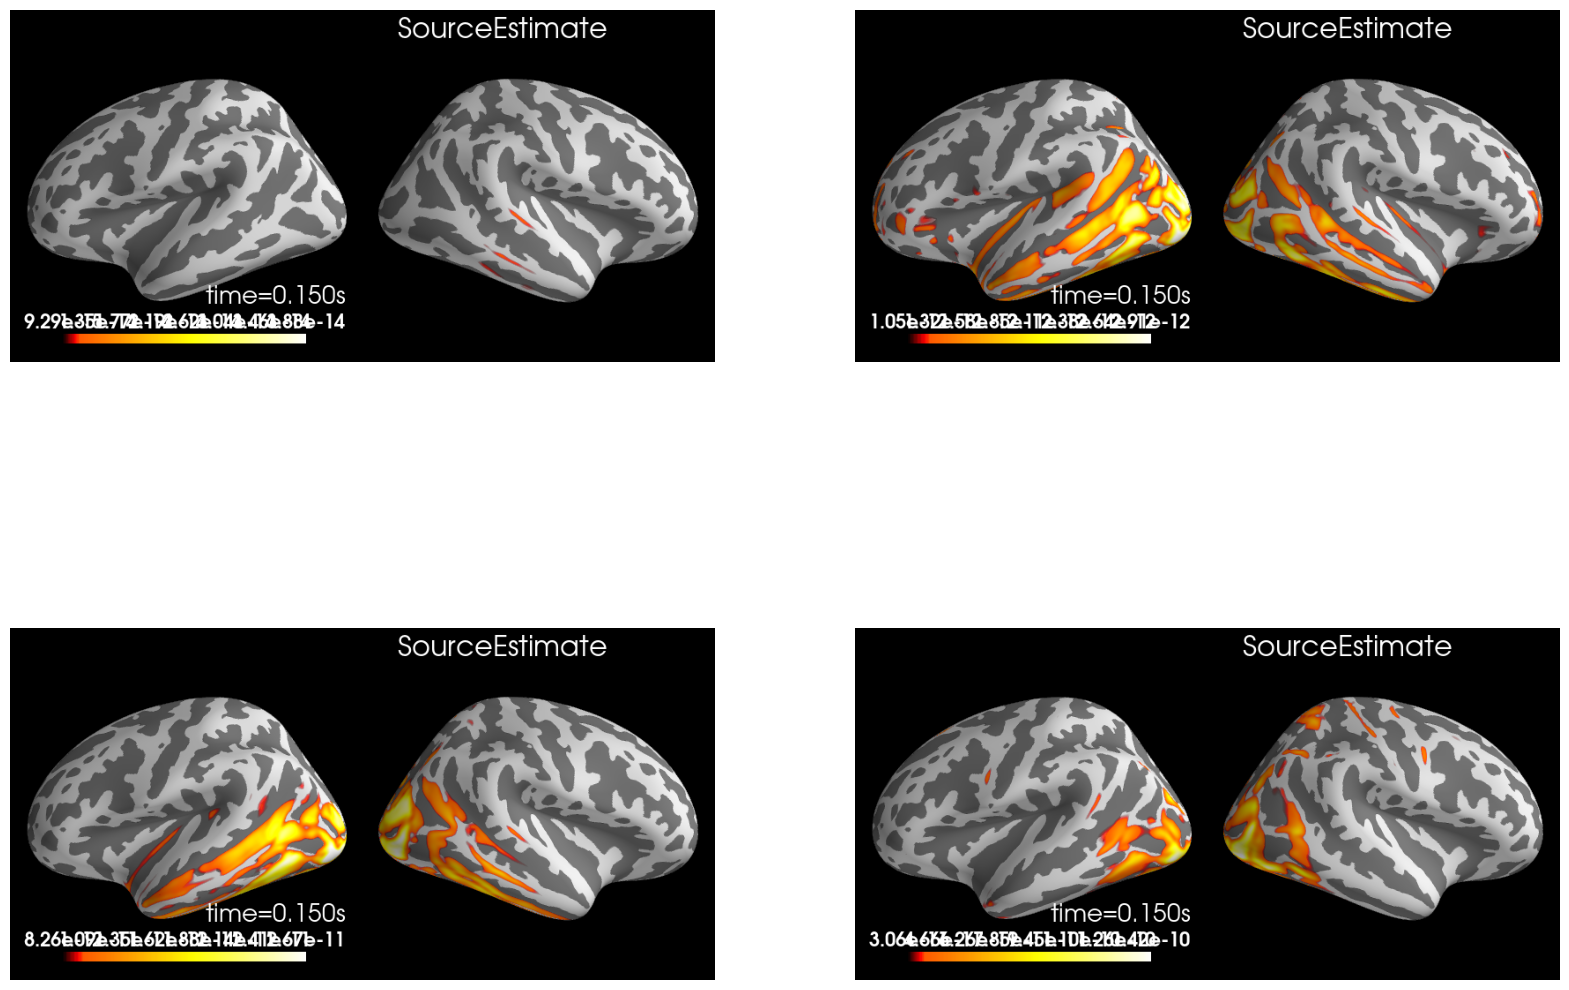

In [ ]:
# plotting parameters
brain_kwargs = dict(views="lateral",hemi='split', size=(800, 400), initial_time=0.15,time_viewer=False,time_unit='s',show_traces=False)

# getting larger figures
plt.rcParams['figure.dpi'] = 100 
plt.rcParams["figure.figsize"] = (20,15)

# a list of all our inverse operators

#loop over inverse operators
for (ix,SNR) in enumerate([0.1,2,10,50]):
    
    lamb = 1.0 / SNR ** 2
    # calculate the stc
    s = apply_inverse(epochs.average(), inv_default, lamb, "MNE", verbose=True)#, pick_ori='vector')
    
    # plot it
    h = s.plot(**brain_kwargs)

    # grab a png from it
    img = ccs_eeg_utils.stc_plot2img(h,closeAfterwards=False)

    # add the png to a subplot
    ax = plt.subplot(2,2,ix+1).imshow(img)
    plt.axis('off')


### Some further notes:

- There are no ideal parameters or algorithms. Different combinations of parameters will introduce different assumptions will lead to potentially very different solutions. One conclusion from our exploration with a single subject might be: Activity comes from visual cortex, but maybe this is something we knew before. 

- So far, we were projecting ERPs conditionwise to the source space. But you can also plot subtractions of conditions, highlighting where the effects occured. Further, you could even directly project betas or difference-waves to source space.

- If you have multiple subjects, and you want to perform statistics, you need to match the head-models of subjects. Given that we do not have individual headmodels, this is no problem for us. All vertices / dipoles are at exactly the same position for all subjects - convenient!

- Performing statistics over subjects works [quite similarly (check out this tutorial)](https://mne.tools/dev/auto_tutorials/stats-source-space/plot_stats_cluster_spatio_temporal.html#sphx-glr-auto-tutorials-stats-source-space-plot-stats-cluster-spatio-temporal-py) to previous analysis. In case of cluster-permutation tests, adjacency/neighbourhood needs to be defined in 3D space on the surface. Computation time might be increased enourmously.

- All of our source-space analysis have been performed on the surface of the cortex. This is where the gray matter is, and where we hypothesize that our EEG signal is produced. But we might be wrong, there might be deep-sources, e.g. hippocampus or cerebellum also generating our potentials. Thus instead of restricting our source analysis to the surface, we could also make use of the whole 3D volume of the brain. This is less well documented in MNE, but also possible. In some sense it is a question of preference.

- Again my warning: Do not overinterpret your source analysis results! You might be centimeters away from your real activity.
